<h2>S&P 500 Sentiment Analysis Based on the "When Is a Liability Not a
Liability?
 Textual Analysis, Dictionaries, and 10-Ks" work by TIM LOUGHRAN and BILL
 MCDONALD.<h2>


In [ ]:
# import project packages
import wrds
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sec_edgar_downloader import Downloader
import time
import calendar
from bs4 import BeautifulSoup
import os
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import pysentiment2 as ps
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# this function retrieves all sp500 records from the WRDS database
# the records are returned in Pandas dataframe format
def get_sp500_records():
    WRDS_USERNAME = 'denisfench'
    # establish connection to the WRDS database
    conn = wrds.Connection(wrds_username=WRDS_USERNAME)

    ### Get S&P500 Index Membership from CRSP
    sp500 = conn.raw_sql("""
                            select a.*, b.date, b.ret
                            from crsp.msp500list as a,
                            crsp.msf as b
                            where a.permno=b.permno
                            and b.date >= a.start and b.date<= a.ending
                            and b.date>='01/01/2000'
                            order by date;
                            """, date_cols=['start', 'ending', 'date'])

    ### Add Other Company Identifiers from CRSP.MSENAMES, such as TICKER, SHRCD, EXCHCD
    mse = conn.raw_sql("""
                            select comnam, ncusip, namedt, nameendt,
                            permno, shrcd, exchcd, hsiccd, ticker
                            from crsp.msenames
                            """, date_cols=['namedt', 'nameendt'])

    # if nameendt is missing then set to today date
    mse['nameendt']=mse['nameendt'].fillna(pd.to_datetime('today'))

    # Merge with SP500 data
    sp500_full = pd.merge(sp500, mse, how = 'left', on = 'permno')

    # Impose the date range restrictions
    sp500_full = sp500_full.loc[(sp500_full.date>=sp500_full.namedt) \
                                & (sp500_full.date<=sp500_full.nameendt)]

    ### Add Other Company Identifiers from CRSP.MSENAMES
    mse = conn.raw_sql("""
                            select comnam, ncusip, namedt, nameendt,
                            permno, shrcd, exchcd, hsiccd, ticker
                            from crsp.msenames
                            """, date_cols=['namedt', 'nameendt'])

    # if nameendt is missing then set to today date
    mse['nameendt']=mse['nameendt'].fillna(pd.to_datetime('today'))

    # Merge with SP500 data
    sp500_full = pd.merge(sp500, mse, how = 'left', on = 'permno')

    # Impose the date range restrictions
    sp500_full = sp500_full.loc[(sp500_full.date>=sp500_full.namedt) \
                                & (sp500_full.date<=sp500_full.nameendt)]

    ### Add Compustat Identifiers
    ccm=conn.raw_sql("""
                      select gvkey, liid as iid, lpermno as permno,
                      linktype, linkprim, linkdt, linkenddt
                      from crsp.ccmxpf_linktable
                      where substr(linktype,1,1)='L'
                      and (linkprim ='C' or linkprim='P')
                      """, date_cols=['linkdt', 'linkenddt'])

    # if linkenddt is missing then set to today date
    ccm['linkenddt']=ccm['linkenddt'].fillna(pd.to_datetime('today'))

    # Merge the CCM data with S&P500 data
    # First just link by matching PERMNO
    sp500ccm = pd.merge(sp500_full, ccm, how='left', on=['permno'])

    # Then set link date bounds
    sp500ccm = sp500ccm.loc[(sp500ccm['date']>=sp500ccm['linkdt'])\
                            &(sp500ccm['date']<=sp500ccm['linkenddt'])]

    # Rearrange columns for final output
    sp500ccm = sp500ccm.drop(columns=['namedt', 'nameendt', 'linktype', \
                                      'linkprim', 'linkdt', 'linkenddt'])
    sp500ccm = sp500ccm[['date', 'permno', 'comnam', 'ncusip',\
                         'shrcd', 'exchcd', 'hsiccd', 'ticker', \
                         'gvkey', 'iid', 'start', 'ending', 'ret']]

    ### Add CIKs and Link with SEC Index Files using CIK
    names = conn.raw_sql(""" select gvkey, cik, sic, naics, gind, gsubind from comp.names """)

    # Merge sp500 constituents table with names table
    sp500 = pd.merge(sp500ccm, names, on='gvkey',  how='left')
    return sp500

In [ ]:
# this function retrieves a subsample of the sp500 records corresponding to
# the given dates (YYYY-MM-DD)
# EX: get_sp500_records_by_date(sp500, '2020-01-01', '2021-12-31')

def get_sp500_records_by_date(sp500_record, start_date, end_date):
    new_sp500_sample = sp500_record.loc[start_date <= sp500_record
        .date][['date',
                                                                    'permno',
                                                      'comnam',
                                               'ncusip', 'gvkey', 'iid', 'cik', 'ticker', 'sic', 'naics']]

    new_sp500_sample = new_sp500_sample.loc[sp500_record.date <=
                                      end_date][['date',
                                                                        'permno',
                                                          'comnam',
                                                   'ncusip', 'gvkey', 'iid', 'cik', 'ticker', 'sic', 'naics']]

    return new_sp500_sample

In [ ]:
# increment the current date by 1 month
def get_next_month(date, DATE_FORMAT="%Y-%m-%d", datetime_format=False):
    datetime_date = datetime.strptime(date, DATE_FORMAT)
    new_date = datetime_date + relativedelta(months=1)
    if datetime_format:
        return new_date
    else:
        return new_date.strftime(DATE_FORMAT)


# increment the current date by 1 day
def get_next_day(date, datetime_format=False):
    DATE_FORMAT = "%Y-%m-%d"
    datetime_date = datetime.strptime(date, DATE_FORMAT)
    new_date = datetime_date + relativedelta(days=1)
    if datetime_format:
        return new_date
    else:
        return new_date.strftime(DATE_FORMAT)


# get the last day of the current month
def get_end_month_date(curr_date, datetime_format=False):
    DATE_FORMAT = "%Y-%m-%d"
    datetime_date = datetime.strptime(curr_date, DATE_FORMAT)
    current_date = curr_date
    month_end_date = current_date[:8] + str(calendar.monthrange(datetime_date.year,
                                                datetime_date
                                      .month)[1])
    month_end_date = datetime.strptime(month_end_date, DATE_FORMAT)
    if datetime_format:
        return month_end_date
    else:
        return month_end_date.strftime(DATE_FORMAT)

In [ ]:
# this function retrieves all 10-K and 10-Q fillings for a given company for
# a given month
def get_filing_by_month(ciks, date, dir_name):
    num_filings = 0
    dl = Downloader(dir_name)
    for cik in ciks:
        num_filings += dl.get("10-Q", cik, after=date, before=get_next_month
        (date))
        num_filings += dl.get("10-K", cik, after=date, before=get_next_month
        (date))
    return num_filings

# this function retrieves all 10-K and 10-Q fillings for a given company for
# a given day
def get_filing_by_day(ciks, date, dir_name):
    num_filings = 0
    dl = Downloader(dir_name)
    for cik in ciks:
        num_filings += dl.get("10-Q", cik, after=date, before=get_next_day
        (date))
        num_filings += dl.get("10-K", cik, after=date, before=get_next_day
        (date))
    return num_filings

In [ ]:
# this function retrieves all S&P 500 10-Q or 10-K filings for a given month,
# if such a filing exists for a given company and writes them to a given directory
# the date should be passed in the following format: YYYY-MM-DD
# the company lookup is based in the cik number by default
def get_all_sp_filings_by_month(sp500_collection, date, dir_name,
                                identifier='cik'):
    sp500_ids = []
    num_filings = 0
    DATE_FORMAT = "%Y-%m-%d"
    current_date = date
    month_end_date = get_end_month_date(current_date, datetime_format=True)

    while datetime.strptime(current_date, DATE_FORMAT) <= month_end_date:
        sp500_companies = sp500_collection.loc[sp500_collection.date ==
                                               current_date][['date',
                                                                        'permno',
                                                          'comnam',
                                                   'ncusip', 'gvkey', 'iid', 'cik', 'ticker', 'sic', 'naics']]

        sp500_ids.extend(sp500_companies[identifier].tolist())
        current_date = get_next_day(current_date)

    num_filings += get_filing_by_month(sp500_ids,
                                       current_date,
                                       dir_name)

    return num_filings

# this function retrieves all S&P 500 10-Q or 10-K filings for a given day,
# if such a filing exists for a given company and writes them to a given directory
# the date should be passed in the following format: YYYY-MM-DD
def get_all_sp_filings_by_day(sp500_collection, date, dir_name, identifier='cik'):
    num_filings = 0
    sp500_companies = sp500_collection.loc[sp500_collection.date == date][['date',
                                                                    'permno',
                                                      'comnam',
                                               'ncusip', 'gvkey', 'iid', 'cik', 'ticker', 'sic', 'naics']]
    sp500_tickers = sp500_companies[identifier]

    for ticker in sp500_tickers:
        num_filings += get_filing_by_day(ticker, date, dir_name)

    return num_filings

In [ ]:
# this function retrieves all S&P 500 10-Q and 10-K filings for a given period
def get_sp500_filings(sp500_collection, filings_start_date, filings_end_date,
                      dir_name):

    print("Retrieving all the 10-Q and 10-K filings starting from ",
           filings_start_date, " until ", filings_end_date)

    DATE_FORMAT = "%Y-%m-%d"
    current_date = filings_start_date
    num_filings = 0
    while datetime.strptime(current_date, DATE_FORMAT) <= datetime.strptime\
                (filings_end_date, DATE_FORMAT):
        num_filings += get_all_sp_filings_by_month(sp500_collection, current_date,
                                                   dir_name)
        current_date = get_next_month(current_date)

        print("Successfully retrieved " + str(num_filings) + " for " + str
        (current_date))

    return num_filings

In [ ]:
# this function retrieves all tickers or ciks for all companies from a given
# directory
def get_all_filing_ids(dir_name):
    ids = os.listdir(dir_name + "/sec-edgar-filings")
    return ids

In [ ]:
# this function extracts the filing date, given the filing date line from the
# filing document
def extract_filing_date(filed_as_of_date_line):
    DATE_FORMAT = "%Y%m%d"
    date = ""
    for ch in filed_as_of_date_line:
        if ch.isdigit():
            date += ch
    return datetime.strptime(date, DATE_FORMAT).date()

In [ ]:
FILING_DETAILS = "filing-details.html"
FULL_SUBMISSION = "full-submission.txt"
FILED_AS_OF_DATE_IDX = 7

# this function will search for a filing in a given directory based on the
# given ticker or cik
# it will return a dictionary with a ticker and the date of filing as the key
# and filing text as the value
# currently the function doesn't indicate whether the filing is a 10-Q or 10-K
def get_filings_from_id(comp_id, dir_name, sec_filings):
    for root, dirs, files in os.walk(dir_name + "/sec-edgar-filings/" + comp_id):
        for f in files:
            if FILING_DETAILS in f:
                with open(root + "/" + f) as fp:
                    soup = BeautifulSoup(fp, "html.parser")
                    line_idx = 0
                    with open(root + "/" + FULL_SUBMISSION) as fs_fp:
                        while line_idx < FILED_AS_OF_DATE_IDX:
                            line_idx += 1
                            fs_fp.readline()
                        date = extract_filing_date(fs_fp.readline())
                    sec_filings[(comp_id, date)] = soup.get_text()
    return sec_filings

In [ ]:
# get filing body for all filings in the list containing filing ids
def get_filings_from_comp_ids(ids, dir_name):
    sec_filings = {}
    for comp_id in ids:
        # sec_filings[comp_id] = get_filings_from_id(comp_id, dir_name, sec_filings)
        get_filings_from_id(comp_id, dir_name, sec_filings)
    return sec_filings

In [ ]:
import ssl

# this function sets up SSL context for downloading packages from nltk library
def create_ssl_context():
    try:
        _create_unverified_https_context = ssl._create_unverified_context
    except AttributeError:
        pass
    else:
        ssl._create_default_https_context = _create_unverified_https_context

In [ ]:
# a function that tokenizes 10-K or 10-Q corpus that
def tokenize_filing(filing_corpus):
    filing_tokenizer = RegexpTokenizer(r'\w+')
    return filing_tokenizer.tokenize(filing_corpus)

In [ ]:
# a function to remove the stop words from the filings corpus
def filter_out_stopwords(tokenized_filing_corpus):
    stop_words = set(stopwords.words('english'))
    filing_corpus_filtered = [word for word in tokenized_filing_corpus if not \
        word.lower() in stop_words]
    return filing_corpus_filtered


# a function that filters out numbers from a filing corpus
def filter_out_numbers(filing_corpus):
    return [token for token in filing_corpus if not (token.isdigit()
                                         or token[0] == '-' and token[1:].isdigit())]

In [ ]:
# this function filters out both the stop words and the numbers
def clean_filing_corpus(tokenized_filing_corpus):
    stop_words = set(stopwords.words('english'))
    filing_corpus_filtered = [word for word in tokenized_filing_corpus if not \
        word.lower() in stop_words and word if not (word.isdigit()
                                         or word[0] == '-' and word[1:].isdigit())]
    return filing_corpus_filtered

In [ ]:
# Perform sentiment analysis on 10-Q and 10-K filing documents

# this function calculates the sentiment score of the text based on a
# sentiment dictionary (Loughran or Harvard), passed in as a parameter
def get_sentiment_score(text, dictionary):

    # get the Harvard general sentiment dictionary
    hiv4 = ps.HIV4()

    # get the Loughran and McDonald dictionary
    lm = ps.LM()

    if dictionary == "Harvard":
        return hiv4.get_score(text)

    if dictionary == "Loughran":
        return lm.get_score(text)

    raise ValueError("The dictionary could not be found.")

In [ ]:
# this function retrieves Value-Weighted Return (including distributions) and
# Holding Period Return from the CRSP database
def get_crsp_data():
    CRSP_DATA_DIR = "CRSP-data/"
    crsp_df = pd.read_csv(CRSP_DATA_DIR + "crsp_2020_2021.csv", parse_dates=['date'])
    return crsp_df

In [ ]:
PERMNO_IDX = 2

def get_permno_from_ticker(sp500, ticker):
    return int(sp500.loc[sp500['ticker'] == ticker, 'permno'].iloc[PERMNO_IDX])

In [ ]:
# this function calculates excess return using Value-Weighted Return (including distributions) and
# Holding Period Return from the CRSP database
def get_excess_return(crsp_dataframe, permno, date):
    excess_return_df = crsp_dataframe[crsp_dataframe['PERMNO'] == permno]
    excess_return_df =  excess_return_df[crsp_dataframe['date'] == date]
    excess_return = float(excess_return_df['RET']) - float\
(excess_return_df['vwretd'])
    return excess_return

In [ ]:
DICTIONARY_DIR = "dictionaries/"

# this function constructs a sentiment dictionary based on the Loughran
# McDonald and Harvard dictionaries
# return: {Term: [str], Sentiment: [int], Term_Count: [int]}
# where Term count is the number of times the term occurs within the corpus
def construct_sentiment_dict(base_dict="Loughran"):
    if base_dict == "Loughran":
        df = pd.read_csv(DICTIONARY_DIR +
                         "Loughran-McDonald_MasterDictionary_1993-2021.csv",
                         header=0, usecols=['Word', 'Negative'])
        df = df[(df['Negative'] != 0)]

    else:
        df = pd.read_csv(DICTIONARY_DIR + "Harvard_Negative_Word_List.txt",
                         sep='/n')

    return df

In [ ]:
# This function constructs a term dictionary based on a given document: tokenized filing list
# return: {Term: [str], Term_Count: [int]}
# where Term count is the number of times the term occurs within the document
def construct_term_dict(document):
    doc_dict = {}
    if isinstance(document, str):
        document_tokens = document.split()
    else:
        document_tokens = document
    for token in document_tokens:
        token = ' '.join(token)
        if token in doc_dict:
            doc_dict[token] += 1
        else:
            doc_dict[token] = 1
    return doc_dict

In [ ]:
# This function calculates a document negativity score based on the
# proportion of negative words in the document
# the negativity of the term is determined based on a given dictionary
# (Loughran or Harvard)
def compute_negativity_score_based_on_proportion(text,
                                                 sentiment_dict="Loughran"):
    sentiment_score = get_sentiment_score(text, sentiment_dict)
    num_negative = sentiment_score['Negative']
    return num_negative / len(text)

In [ ]:
# This function calculates TFIDF score for the filings based on the sentiment
# dictionary vocabulary using SciKit Learn
def calc_tfidf_score(corpus_of_filings):
    vectorizer = TfidfVectorizer(
                             stop_words="english")
    vectors = vectorizer.fit_transform(corpus_of_filings)
    feature_names = vectorizer.get_feature_names()
    dense = vectors.todense()
    dense_list = dense.tolist()
    tfidf_df = pd.DataFrame(dense_list, columns=feature_names)
    return tfidf_df

In [ ]:
# this function loads all the filings from a given directory, which
# constitute an entire corpus of documents
def load_filings_corpus(corpus_root_dir):
    FILING_DETAILS = "filing-details.html"
    sec_filings_corpus = []
    for root, dirs, files in os.walk(corpus_root_dir + "/sec-edgar-filings/"):
        for f in files:
            if FILING_DETAILS in f:
                with open(root + "/" + f) as file_ptr:
                    bs = BeautifulSoup(file_ptr, "html.parser")
                    sec_filings_corpus.append(bs.get_text())
    return sec_filings_corpus

In [ ]:
# this function plots negativity score (quantile) vs median excess return for a
# sample
# of companies

def plot_negativity_vs_median_excess_return\
(quantile, median_filing_period_excess_return, label):
    plt.xlabel('Quintile (based on proportion of negative words)')
    plt.ylabel('Median Filling Period Excess Return')
    plt.plot(quantile, median_filing_period_excess_return
             , label=label)
    plt.legend()
    plt.show()

<h1>SENTIMENT ANALYSIS OF 10-Qs and 10-Ks for S&P 500 companies for 2020,
2021<h1>

In [ ]:
create_ssl_context()

In [ ]:
# getting all S&P 500 records from the WRDS database

sp500_all = get_sp500_records()

In [ ]:
# retrieving all S&P 500 records for the two-year period (from '2020-01-01'
# to '2021-12-31')

sp500_sample = get_sp500_records_by_date(sp500_all, "2020-01-01", "2021-12-31")
sp500_sample.head()

In [ ]:
# get a sample of S&P 500 filings for a 2-year period
start_date = "2020-01-01"
end_date = "2021-12-31"
sp_filings_dir_name = 'sp500_filings_sample'
num_filings_sample = get_sp500_filings(sp500_sample, start_date, end_date, sp_filings_dir_name)

In [37]:
FILINGS_SAMPLE_DIR = "data"
# retrieving tickers of companies who's filings we have in our file system
sample_ids = get_all_filing_ids(FILINGS_SAMPLE_DIR)

In [38]:
load_serialized_version = True
SERIALIZATION_DIR = "serialized/"

sample_filings_corpus = {}

if (load_serialized_version):
    print("Loading serialized version...")
    try:
        sample_filings_corpus = pickle.load(open(SERIALIZATION_DIR +
                                                 "sample_filings_corpus"
                                                 ".pickle", "rb"))
    except (OSError, IOError) as e:
        print("Serialized version was not found. Retrieving filings and "
              "creating a serialized file.")
        sample_filings_corpus = get_filings_from_comp_ids(sample_ids,
                                                        FILINGS_SAMPLE_DIR)
        pickle.dump(sample_filings_corpus, open(SERIALIZATION_DIR +
                                                "sample_filings_corpus"
                                                ".pickle", "wb"))
        print("Done!")

else:
    sample_filings_corpus = get_filings_from_comp_ids(sample_ids, FILINGS_SAMPLE_DIR)

Loading serialized version...


In [39]:
# tokenize and clean the body of the filings
print("Tokenizing and cleaning the filings...")

for filing in sample_filings_corpus:
    filing_text = sample_filings_corpus[filing]
    # extract a list of tokens from the filing corpus
    tokenized_filing = tokenize_filing(filing_text)
    # remove the stop words and digits from the tokenized filing
    tokenized_filing = clean_filing_corpus(tokenized_filing)
    sample_filings_corpus[filing] = tokenized_filing

Tokenizing and cleaning the filings...


In [40]:
# calculating sentiment score of each filing based on the proportion of
# negative words present in it based on Loughran and Harvard dictionaries

# filings_loughran_neg_score: { (ticker, date) : (loughran_neg_score,
# harvard_neg_score) }

filings_neg_score = {}

for filing in sample_filings_corpus:
    list_of_filing_tokens = sample_filings_corpus[filing]
    loughran_neg_score = get_sentiment_score(list_of_filing_tokens, "Loughran")
    harvard_neg_score = get_sentiment_score(list_of_filing_tokens, "Harvard")
    filings_neg_score[filing] = (loughran_neg_score, harvard_neg_score)

In [41]:
# loading financial data from CRSP database
# the data has been preloaded from CRSP in a form of csv file

print("Loading CRSP data...")
sample_crsp_data = get_crsp_data()

Loading CRSP data...


/var/folders/4l/kfc4gh5d1jn6zkrmv51vvbyw0000gn/T/ipykernel_18992/377214008.py:5: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  crsp_df = pd.read_csv(CRSP_DATA_DIR + "crsp_2020_2021.csv", parse_dates=['date'])


In [42]:
# calculating excess return for all companies in our sample

print("Calculating excess return for all companies in our sample...")

# filings_excess_return : {(ticker, date) : excess_return}
filings_excess_return = {}

for filing in sample_filings_corpus:
    filing_ticker = filing[0]
    filing_date = filing[1]
    DATE_FORMAT = "%Y-%m-%d"
    datetime_date = datetime.strftime(filing_date, DATE_FORMAT)
    filing_permno = get_permno_from_ticker(sp500_sample, filing_ticker)
    filing_excess_return = get_excess_return(sample_crsp_data, filing_permno,
                                             datetime_date)
    filings_excess_return[filing] = filing_excess_return

Calculating excess return for all companies in our sample...


/var/folders/4l/kfc4gh5d1jn6zkrmv51vvbyw0000gn/T/ipykernel_18992/135129160.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  excess_return_df =  excess_return_df[crsp_dataframe['date'] == date]


<h2> Performing proportion of negative words analysis on the sp500 sample </h2>

In [43]:
print("Collecting negativity score for filings in our dataset and their "
      "corresponding excess returns")

filings_negativity_score_prop = []
sample_filings_excess_return = []
filing_lengths = []

for filing in sample_filings_corpus:
    filing_lengths.append(len(sample_filings_corpus[filing]))
    filings_negativity_score_prop.append(filings_neg_score[filing])
    sample_filings_excess_return.append(filings_excess_return[filing])

In [44]:
print("Separating proportion of negative words results for Loughran and "
      "Harvard dictionaries")

filings_negativity_score_prop_lr = []
filings_negativity_score_prop_hv = []

idx = 0

for sentiment_score in filings_negativity_score_prop:
    filings_negativity_score_prop_lr.append(sentiment_score[0]['Negative'] /
                                            filing_lengths[idx])
    filings_negativity_score_prop_hv.append(sentiment_score[1]['Negative'] /
                                            filing_lengths[idx])
    idx += 1

Separating proportion of negative words results for Loughran and Harvard dictionaries


Displaying the final result for negativity proportion analysis for Loughran dictionary


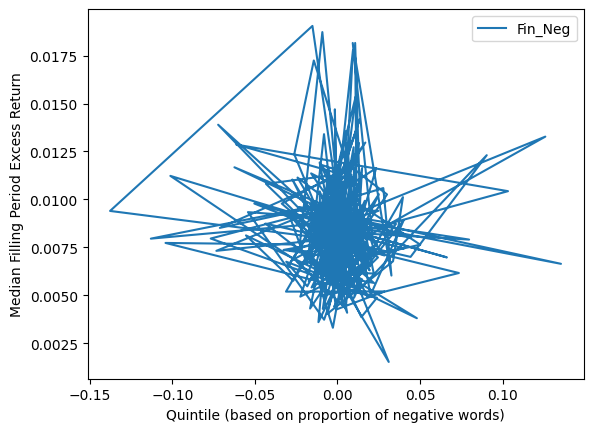

In [45]:
print("Displaying the final result for negativity proportion analysis for "
      "Loughran dictionary")

plot_negativity_vs_median_excess_return(sample_filings_excess_return,
                                        filings_negativity_score_prop_lr, "Fin_Neg")

Displaying the final result for negativity proportion analysis for Harvard dictionary


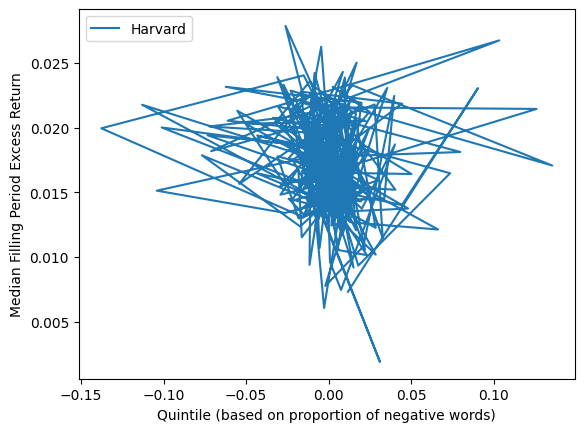

In [46]:
print("Displaying the final result for negativity proportion analysis for "
      "Harvard dictionary")

plot_negativity_vs_median_excess_return(sample_filings_excess_return,
                                        filings_negativity_score_prop_hv, "Harvard")

<h2>Performing TFIDF-based analysis on the sp500 sample<h2>

In [ ]:
# constructing a sentiment dictionary based on the Loughran financial-term
# dictionary
# the dictionary itself has been preloaded as a csv file
print("Constructing sentiment dictionary based on the Loughran financial-term dictionary")

loughran_sentiment_dict = construct_sentiment_dict()
loughran_sentiment_dict.head()

In [ ]:
print("Constructing sentiment dictionary based on the Harvard general sentiment dictionary")

harvard_sentiment_dict = construct_sentiment_dict("Harvard")
harvard_sentiment_dict.head()

In [ ]:
# calculating TFIDF score for every filing within the corpus
load_serialized_version = True
SERIALIZATION_DIR = "serialized/"

print("Calculating TFIDF scores for all tokens in all filings")

# retrieving filing body from each filing within the corpus
filings_corpus = []

for filing_body in sample_filings_corpus.values():
    filings_corpus.extend(filing_body)

# calculating TFIDF scores for each of the terms within the corpus
if load_serialized_version:
    print("Loading serialized version of tfidf_score_map")
    try:
        tfidf_score_map = pickle.load(open(SERIALIZATION_DIR + "tfidf_score_map.pickle", "rb"))
    except (OSError, IOError) as e:
        print("Serialized version of tfidf_score_map was not found, creating "
              "the map from scratch...")
        tfidf_score_map = calc_tfidf_score(filings_corpus)
        pickle.dump(tfidf_score_map, open(SERIALIZATION_DIR +
                                          "tfidf_score_map.pickle", "wb"))
else:
    tfidf_score_map = calc_tfidf_score(filings_corpus)

In [ ]:
# this function calculates negativity score of the document based on the
# tfidf score
def calculate_tfids_neg_score(document, doc_idx, tfidf_corpus_scores, \
 dictionary):
    curr_neg_score = 0
    doc_term_dict = construct_term_dict(document)
    for term in doc_term_dict:
        if term.upper() in dictionary['Word'].values:
            curr_neg_score += tfidf_corpus_scores.iloc[[doc_idx]][term]
    return curr_neg_score / len(document)

In [ ]:
# calculating tfidf negativity scores for all the documents in our collection

print("Collecting tfidf negativity score for filings in our dataset and their "
      "corresponding excess returns using Loughran and Harvard dictionaries.")

filings_tfidf_neg_score = {}

doc_idx = 0

for filing in sample_filings_corpus:

        filing_tfidf_score_lr = calculate_tfids_neg_score\
(sample_filings_corpus[filing], doc_idx, tfidf_score_map, loughran_sentiment_dict)

        filing_tfidf_score_hv = calculate_tfids_neg_score\
(sample_filings_corpus[filing], doc_idx, tfidf_score_map, harvard_sentiment_dict)

        filings_tfidf_neg_score[filing] = (filing_tfidf_score_lr, filing_tfidf_score_hv)

        doc_idx += 1


filings_negativity_score_tfidf_lr = []
filings_negativity_score_tfidf_hv = []
sample_filings_excess_return = []

for filing in sample_filings_corpus:

    filings_negativity_score_tfidf_lr.append\
(filings_tfidf_neg_score[filing][0])

    filings_negativity_score_tfidf_hv.append(filings_tfidf_neg_score[filing][1])

    sample_filings_excess_return.append(filings_excess_return[filing])

In [ ]:
print("Displaying the final result for TFIDF analysis using Loughran dictionary")

plot_negativity_vs_median_excess_return(filings_negativity_score_tfidf_lr, sample_filings_excess_return)

In [ ]:
print("Displaying the final result for TFIDF analysis using Harvard dictionary")

plot_negativity_vs_median_excess_return(filings_negativity_score_tfidf_hv, sample_filings_excess_return)